# Sentiment Analysis
- Brigitte Hogan (bwh5v@virginia.edu) & Jason Tiezzi (jbt5am@virginia.edu)
- DS 5001: Exploratory Text Analytics
- April 2020

## Overview

This notebook calculates the sentiment for both the book and the time period, first using VADER and then using a pure lexicon-based approach (EmoLex, from NRC). It also calculates emotional dimension scores based on EmoLex. 

## Set Up

In [1]:
OHCO = ['period','book_id', 'vol_num','chap_num', 'recp_num','para_num', 'sent_num', 'token_num']

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns
sns.set()
import math
import nltk


In [3]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

### Import Files

In [4]:
file_dir = 'C:/Users/Jason/Documents/Data Science/Spring 2020/Text Analytics/final_project/DS5001-Text-Analytics/'
data_dir = 'Tables/'
os.chdir(file_dir)

In [5]:
LIB = pd.read_csv(data_dir + 'LIB.csv')
LIB.head()

,book_id,author_last,author_full,book_year,book_title,book_file,period
0,9935,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks/WIDAS1923_WILCV01_pg9935.txt,1900s
1,9936,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 2",Cookbooks/WIDAS1923_WILCV02_pg9936.txt,1900s
2,9937,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 3",Cookbooks/WIDAS1923_WILCV03_pg9937.txt,1900s
3,9938,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 4",Cookbooks/WIDAS1923_WILCV04_pg9938.txt,1900s
4,9939,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 5",Cookbooks/WIDAS1923_WILCV05_pg9939.txt,1900s


In [6]:
VOCAB = pd.read_csv(data_dir + 'VOCAB.csv')
VOCAB.head()

,term_id,term_str,n,num,has_int,stop,stem_porter,stem_snowball,TFIDF_sum_book_x,TFIDF_sum_recipe_x,TFIDF_sum_period_x,TFIDF_sum_book_y,TFIDF_sum_recipe_y,TFIDF_sum_period_y,TFIDF_sum_period
0,15108,the,60407,0,0,1,the,the,0.0,14.919713,0.0,0.0,14.919713,0.0,0.0
1,10502,of,35149,0,0,1,of,of,0.0,13.203503,0.0,0.0,13.203503,0.0,0.0
2,1546,and,33319,0,0,1,and,and,0.0,7.244055,0.0,0.0,7.244055,0.0,0.0
3,1062,a,28726,0,0,1,a,a,0.0,12.451291,0.0,0.0,12.451291,0.0,0.0
4,8071,in,22204,0,0,1,in,in,0.0,9.951277,0.0,0.0,9.951277,0.0,0.0


In [7]:
TOKEN = pd.read_csv(data_dir + 'TOKEN.csv')
TOKEN.head()

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str
0,9935,1,1,1.0,0,0,0,"('1', 'CD')",CD,1,1
1,9935,1,1,1.0,0,0,1,"('.', '.')",.,.,NaN
2,9935,1,1,1.0,0,1,0,"('Without', 'IN')",IN,Without,without
3,9935,1,1,1.0,0,1,1,"('doubt', 'NN')",NN,doubt,doubt
4,9935,1,1,1.0,0,1,2,"(',', ',')",",",",",NaN


In [8]:
TOKEN.shape

(1130904, 11)

In [9]:
#merging the library and TOKEN tables together
TOKEN = pd.merge(TOKEN, LIB, on="book_id", how="left")
TOKEN.shape

(1130904, 17)

In [10]:
#merging the token and VOCAB tables together os I can have access to stop words, numbers, etc. 
TOKEN = pd.merge(TOKEN, VOCAB, on='term_str')
TOKEN.head()

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,author_last,author_full,book_year,book_title,book_file,period,term_id,n,num,has_int,stop,stem_porter,stem_snowball,TFIDF_sum_book_x,TFIDF_sum_recipe_x,TFIDF_sum_period_x,TFIDF_sum_book_y,TFIDF_sum_recipe_y,TFIDF_sum_period_y,TFIDF_sum_period
0,9935,1,1,1.0,0,0,0,"('1', 'CD')",CD,1,1,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks/WIDAS1923_WILCV01_pg9935.txt,1900s,14,4035,1,1,0,1,1,0.00964,25.807714,0.0,0.00964,25.807714,0.0,0.0
1,9935,1,5,23.0,0,7,25,"('1', 'CD')",CD,1,1,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks/WIDAS1923_WILCV01_pg9935.txt,1900s,14,4035,1,1,0,1,1,0.00964,25.807714,0.0,0.00964,25.807714,0.0,0.0
2,9935,1,5,23.0,0,8,17,"('1', 'CD')",CD,1,1,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks/WIDAS1923_WILCV01_pg9935.txt,1900s,14,4035,1,1,0,1,1,0.00964,25.807714,0.0,0.00964,25.807714,0.0,0.0
3,9935,1,5,23.0,0,9,22,"('1', 'CD')",CD,1,1,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks/WIDAS1923_WILCV01_pg9935.txt,1900s,14,4035,1,1,0,1,1,0.00964,25.807714,0.0,0.00964,25.807714,0.0,0.0
4,9935,1,5,23.0,1,1,20,"('1', 'CD')",CD,1,1,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks/WIDAS1923_WILCV01_pg9935.txt,1900s,14,4035,1,1,0,1,1,0.00964,25.807714,0.0,0.00964,25.807714,0.0,0.0


## VADER

In [11]:
## getting the corpus into sentences for analysis by VADER
TOKEN = TOKEN.sort_values(by=OHCO)
sent_frame = TOKEN.groupby(OHCO[:7]).token_str.apply(lambda x: ' '.join(x)).to_frame() #getting a string for each sentence 
sent_frame.columns = ['sent_str']
sent_frame

sent_str
period   book_id vol_num chap_num recp_num para_num sent_num                                                                                                                                                                                                                                                                                                                                                         
1900s    9935    1       1        1.0      0        0                                                                                                                                                                                                                                                                                                                                                               1
                                                    1                                                                                                                                                                                                                                                                                   Without doubt the greatest problem confronting the human race is that of food
                                                    2                                                                                                                                                                                                                                                                In order to exist every person must eat but eating simply to keep life in the body is not enough
                                                    3                                                                                                                                                                               Aside from this the body must be supplied with an ample amount of energy to carry on each day 's work as well as with the material needed for its growth repair and working power
                                                    4                                                                                                                                                                                                                      To meet these requirements of the human body there is nothing to take the place of _food_ not merely any kind however but the _right_ kind
...                                                                                                                                                                                                                                                                                                                                                                                                               ...
mid1800s 28681   5       37       38.0     1        4                                                                                                                                                                                                                                                                                On one side there is a part whiter than ordinary by some called the white muscle
                                                    5         In some places a buttock is generally divided and this white part sold separate as a delicacy but it is by no means so the meat being coarse and dry whereas the darker coloured parts though apparently of a coarser grain are of a looser texture more tender fuller of gravy and better flavoured and men of distinguishing palates ever prefer them
                                  39.0     1        0                                                                                                                                                                                                                                                    412 He who greedily grapples for the pri

### Running VADER

In [12]:
def get_sentiment(series): #creating a function to get VADER sentiment of a series
    cols = len(series) #getting the length of the series column
    series = series.reset_index(drop=True)
    sent = np.empty((cols,4)) #creating an empty array to store my results
    for i in range(cols):
        sentence = series[i]
        score = analyzer.polarity_scores(sentence) #getting the four different sentiment values
        sent[i,:] = list(score.values()) #pulling the values out of dictionary and putting them into the array I created
    return sent

In [13]:
text = sent_frame.sent_str 
sentiment_score = get_sentiment(text) 
sentiment_score 

array([[ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.219 ,  0.459 ,  0.322 ,  0.4606],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       ...,
       [ 0.146 ,  0.854 ,  0.    , -0.4404],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  1.    ,  0.    ,  0.    ]])

In [14]:
#adding the results of VADER to my sentence dataframe
sent_frame['VADER_pos'] = sentiment_score[:,2]
sent_frame['VADER_neg'] = sentiment_score[:,0]
sent_frame['VADER_neu'] = sentiment_score[:,1]
sent_frame['VADER_compound'] = sentiment_score[:,3]
sent_frame.head()



sent_str  \
period book_id vol_num chap_num recp_num para_num sent_num                                                                                                                                                                                      
1900s  9935    1       1        1.0      0        0                                                                                                                                                                                         1   
                                                  1                                                                                                             Without doubt the greatest problem confronting the human race is that of food   
                                                  2                                                                                          In order to exist every person must eat but eating simply to keep life in the body is not enough   
                                                  3         Aside from this the body must be supplied with an ample amount of energy to carry on each day 's work as well as with the material needed for its growth repair and working power   
                                                  4                                                To meet these requirements of the human body there is nothing to take the place of _food_ not merely any kind however but the _right_ kind   

                                                            VADER_pos  \
period book_id vol_num chap_num recp_num para_num sent_num              
1900s  9935    1       1        1.0      0        0             0.000   
                                                  1             0.322   
                                                  2             0.000   
                                                  3             0.175   
                                                  4             0.000   

                                                            VADER_neg  \
period book_id vol_num chap_num recp_num para_num sent_num              
1900s  9935    1       1        1.0      0        0             0.000   
                                                  1             0.219   
                                                  2             0.000   
                                                  3             0.000   
                                                  4             0.188   

                                                            VADER_neu  \
period book_id vol_num chap_num recp_num para_num sent_num              
1900s  9935    1       1        1.0      0        0             0.000   
                                                  1             0.459   
                                                  2             1.000   
                                                  3             0.825   
                                                  4             0.812   

                                                            VADER_compound  
period book_id vol_num chap_num recp_num para_num sent_num                  
1900s  9935    1       1        1.0      0        0                 0.0000  
                                                  1                 0.4606  
                                                  2                 0.0000  
                                                  3                 0.7003  
                                                  4                -0.6759

### Grouping by Book

In [15]:
VADER_sentiment_book = sent_frame.groupby('book_id').mean()
VADER_sentiment_book = pd.merge(VADER_sentiment_book, LIB, on='book_id')

Text(0.5, 1.0, 'VADER')

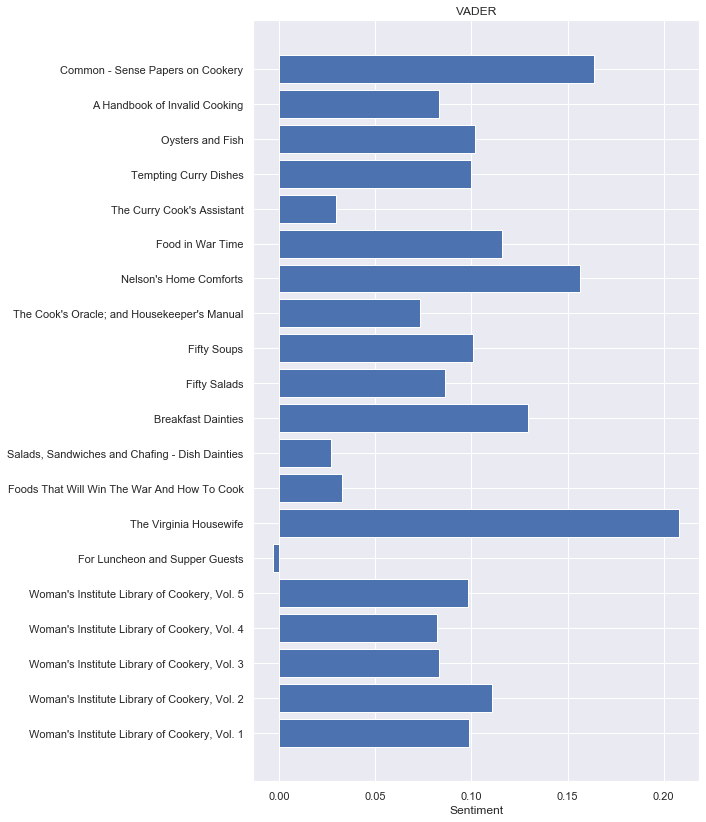

In [16]:
plt.figure(figsize=(8,14))
plt.barh(y=VADER_sentiment_book.book_title, width = VADER_sentiment_book.VADER_compound)
plt.xlabel("Sentiment", fontsize=12)
plt.title("VADER")

As you can see above, most of the books are rated as positive sentiment by VADER, with the exception of "For Luncheon and Supper Guests". The most positive book was "The Virginia Housewife"

### Grouping by Period

In [17]:
VADER_sentiment_period = sent_frame.groupby(OHCO[:1]).mean()
VADER_sentiment_period

,VADER_pos,VADER_neg,VADER_neu,VADER_compound
period,,,,
1900s,0.055842,0.025065,0.904682,0.081663
late1800s,0.067891,0.038268,0.887072,0.104832
mid1800s,0.058731,0.091799,0.839658,0.091498


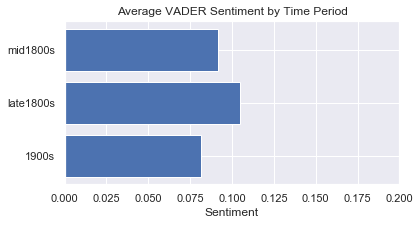

In [18]:
plt.figure(figsize=(6,3))
plt.barh(y=VADER_sentiment_period.index, width = VADER_sentiment_period.VADER_compound)
plt.xlabel("Sentiment", fontsize=12)
plt.xlim(0,.2)
plt.title("Average VADER Sentiment by Time Period")
plt.show()

There don't seem to be major differences by time period

## Sentiment with NRC

In [19]:
sentiment = pd.read_csv(data_dir + 'emolex_sentiment.csv') #reading in the NRC sentiment data
sentiment.head()

,term_str,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
0,abandon,0,0,0,1,0,1,0,1,0,0
1,abandoned,1,0,0,1,0,1,0,1,0,0
2,abandonment,1,0,0,1,0,1,0,1,1,0
3,abduction,0,0,0,1,0,1,0,1,1,0
4,aberration,0,0,1,0,0,1,0,0,0,0


In [20]:
NRC = pd.merge(TOKEN, sentiment, on='term_str', how='left') #merging in the sentiment data to the TOKENS table
NRC.iloc[:,-10:] = NRC.iloc[:,-10:].fillna(0) #filling any missing sentiment values with zero 
NRC_emo = NRC[NRC.stop==0] #removing stopwords
NRC_emo = NRC_emo[NRC_emo.num == 0] #removing integers
NRC_emo = NRC_emo[(NRC_emo.pos != 'NNP') & (NRC_emo.pos != 'NNPS')] #removing proper nouns
NRC_emo = NRC_emo[['period','book_id','vol_num','chap_num', 'recp_num', 'para_num','sent_num','token_num', 'book_year','term_str','nrc_anger','nrc_disgust','nrc_anticipation','nrc_fear','nrc_joy','nrc_negative','nrc_positive', 'nrc_sadness','nrc_surprise','nrc_trust']]
NRC_emo.head()

,period,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,book_year,term_str,nrc_anger,nrc_disgust,nrc_anticipation,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
1,1900s,9935,1,1,1.0,0,1,0,1923,without,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1900s,9935,1,1,1.0,0,1,1,1923,doubt,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1900s,9935,1,1,1.0,0,1,4,1923,greatest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1900s,9935,1,1,1.0,0,1,5,1923,problem,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6,1900s,9935,1,1,1.0,0,1,6,1923,confronting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating Sentiment for Period

In [21]:
NRC_period_sentiment = NRC_emo.groupby(OHCO[:1]).mean()
NRC_period_sentiment['overall_NRC_valence'] = NRC_period_sentiment.nrc_positive - NRC_period_sentiment.nrc_negative #adding a column for overall valence
NRC_period_sentiment


,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,book_year,nrc_anger,nrc_disgust,nrc_anticipation,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,overall_NRC_valence
period,,,,,,,,,,,,,,,,,,,
1900s,11502.489396,2.944521,106.952655,243.795167,1.814082,2.859512,14.053122,1921.324021,0.012079,0.014659,0.024473,0.013138,0.028327,0.034136,0.044949,0.019046,0.011546,0.038097,0.010813
late1800s,49093.698701,0.626005,12.167461,91.825789,8.670037,2.190098,19.023349,1887.017274,0.017409,0.017890,0.026700,0.016089,0.029762,0.041634,0.043935,0.020740,0.014472,0.037080,0.002301
mid1800s,25255.823755,2.213307,20.057594,56.253079,73.285309,0.738984,37.267902,1836.357832,0.017880,0.019037,0.027659,0.011862,0.034015,0.042578,0.046831,0.017822,0.016462,0.041845,0.004253


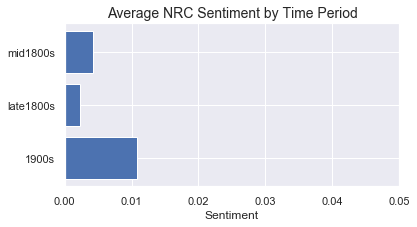

In [22]:
plt.figure(figsize=(6,3))
plt.barh(y=NRC_period_sentiment.index, width = NRC_period_sentiment.overall_NRC_valence)
plt.xlabel("Sentiment", fontsize=12)
plt.xlim(0,.05)
plt.title("Average NRC Sentiment by Time Period", fontsize=14)
plt.show()

As you can see, accorindg to NRC, the 1900s are the most positive period, whereas the late 1800s are the least positive period. As this is the exact oppositie of VADER, it's a pretty clear suggestion that the sentiment methods aren't working great. 

### Calculating Sentiment and Emotional Scores for Book

In [23]:
NRC_book = NRC_emo.groupby(OHCO[:2]).mean()
NRC_book['overall_NRC_valence'] = NRC_book.nrc_positive - NRC_book.nrc_negative #adding a column for the overall valence
NRC_book

vol_num    chap_num    recp_num   para_num  sent_num  \
period    book_id                                                          
1900s     9935     2.996151  105.465841  204.808363   1.812082  3.195433   
          9936     3.962927   98.015777  210.701370   1.026196  3.266187   
          9937     2.964324  122.292594  226.721270   0.748698  3.342187   
          9938     2.802005  168.515513  261.455527   0.831861  2.886249   
          9939     3.339403  149.780235  386.868819   0.707765  3.174203   
          10582    0.000000    5.415936   70.012767   1.219351  1.767882   
          15464    3.103313    8.595824  145.352392   4.913123  1.347189   
          19077    1.830419   14.778517  212.554424   2.020317  1.604629   
          32472    0.000000    1.548601    0.000000  29.506627  2.221159   
late1800s 24205    0.000000    5.488270   43.787648   0.988169  0.929216   
          24542    0.000000    0.000000    1.664474   1.541667  2.006579   
          25007    0.000000    0.000000    0.000000  49.207184  1.648881   
          29519    0.000000    4.656986   80.870911   3.277132  2.232421   
          34107    0.000000    0.000000   28.289730   2.184865  3.649297   
          38464    0.000000    0.000000   19.473073   2.047518  1.543471   
          53521    0.000000    9.485891   69.591191   0.349851  1.659670   
          54568    1.757922   21.406689  201.888628   4.862724  1.780770   
          61185    0.000000   10.627507    0.000000  16.386511  2.993362   
mid1800s  12519    0.000000    9.145210  200.677406   1.068942  0.684869   
          28681    2.808508   22.992144   17.414607  92.705676  0.753537   

                   token_num  book_year  nrc_anger  nrc_disgust  \
period    book_id                                                 
1900s     9935     16.001248     1923.0   0.009388     0.012431   
          9936     14.703793     1923.0   0.012815     0.016665   
          9937     13.515898     1923.0   0.014569     0.018475   
          9938     12.143831     1923.0   0.008882     0.011718   
          9939     13.540838     1923.0   0.012071     0.011624   
          10582    14.399631     1923.0   0.024612     0.010768   
          15464    12.668042     1918.0   0.009836     0.029192   
          19077    14.999434     1909.0   0.014574     0.010093   
          32472    19.083211     1918.0   0.014482     0.024300   
late1800s 24205    19.811911     1885.0   0.020854     0.014438   
          24542    15.554825     1885.0   0.017544     0.017544   
          25007    22.917751     1884.0   0.023946     0.022124   
          29519    19.361510     1892.0   0.019107     0.017884   
          34107    14.314811     1887.0   0.016000     0.015135   
          38464    19.613164     1891.0   0.021823     0.009504   
          53521    18.731016     1888.0   0.030970     0.015944   
          54568    16.436540     1893.0   0.012762     0.017846   
          61185    22.433757     1877.0   0.016808     0.019880   
mid1800s  12519    44.534243     1860.0   0.018885     0.018385   
          28681    35.313843     1830.0   0.017610     0.019213   

                   nrc_anticipation  nrc_fear   nrc_joy  nrc_negative  \
period    book_id                                                       
1900s     9935             0.024679  0.011469  0.025876      0.026500   
          9936             0.027623  0.016046  0.033061      0.038904   
          9937             0.020157  0.016332  0.025312      0.041101   
          9938             0.025801  0.010823  0.031622      0.030627   
          9939             0.027781  0.015018  0.030524      0.029772   
          10582            0.028303  0.010460  0.032610      0.043532   
          15464            0.013327  0.007298  0.017832      0.044105   
          19077            0.022448  0.009267  0.025015      0.032019   
          32472            0.028228  0.022337  0.028964      0.045410   
late1800s 24205            0.029076  0.015240  0.029076      0.044315

In [24]:
### merging with the LIB table
NRC_book_sentiment = pd.merge(NRC_book, LIB, on=['book_id','book_year'])

#### Looking at Emotional Scores by Book

In [25]:
NRC_book_sentiment.sort_values('book_year').set_index(['period','book_year','book_id','vol_num','chap_num','recp_num','para_num','sent_num','token_num']).style.background_gradient(cmap='Greens') 
#sorting by year and then coloring cells to see if any patterns emerge

I'm not seeing a whole lot of signal there, other than ""Foods That Will Win The War And How To Cook" seems to have very little positive emotion and quite a bit of negative emotion. 

#### Looking at Overall Valence by Book

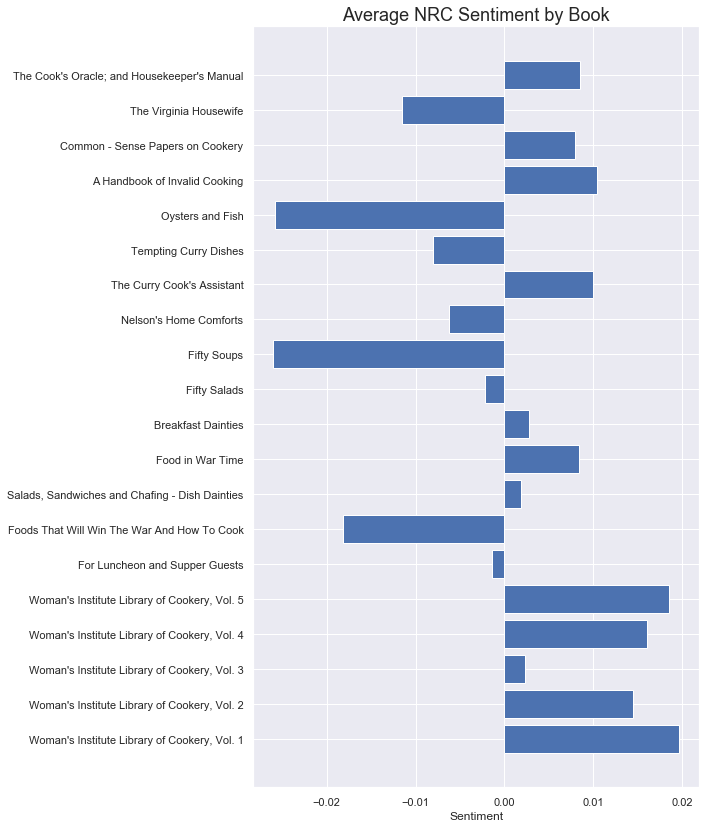

In [26]:
plt.figure(figsize=(8,14))
plt.barh(y=NRC_book_sentiment.book_title, width = NRC_book_sentiment.overall_NRC_valence)
plt.xlabel("Sentiment", fontsize=12)
plt.title("Average NRC Sentiment by Book", fontsize=18)
plt.show()

On balance, a lot of these books are significantly more negative than VADER, and the results don't really seem to have any consistency with VADER. The most negative books for VADER are neutral by this measure, whereas the most negative books in EmoLex were moderately positive in Vader.  

## Combining the Tables Together and Doing a Final Standardized Chart for Comparison

In [27]:
sentiment_book = pd.merge(NRC_book_sentiment, VADER_sentiment_book, on=["book_id","author_last", "period","book_file","author_full","book_year","book_title"]).drop(['author_last','author_full','book_file','book_title'], axis=1)
sentiment_book.set_index(['period','book_year','book_id'], inplace=True)

In [28]:
#Satndardizing values so you can compare them more easily. 
sentiment_book1 = sentiment_book.copy()
sentiment_book1['VADER_compound'] = sentiment_book1['VADER_compound'] / sentiment_book1['VADER_compound'].std()
sentiment_book1['overall_NRC_valence'] = sentiment_book1['overall_NRC_valence'] / sentiment_book1['overall_NRC_valence'].std()


In [29]:
sentiment_book1 = sentiment_book1.reset_index()
chart_data = pd.melt(sentiment_book1, id_vars=['book_id'], value_vars=['VADER_compound','overall_NRC_valence'])
chart_data1 = pd.merge(LIB,chart_data, on='book_id')
chart_data1.replace("VADER_compound","VADER", inplace=True)
chart_data1.replace("overall_NRC_valence","EmoLex", inplace=True)


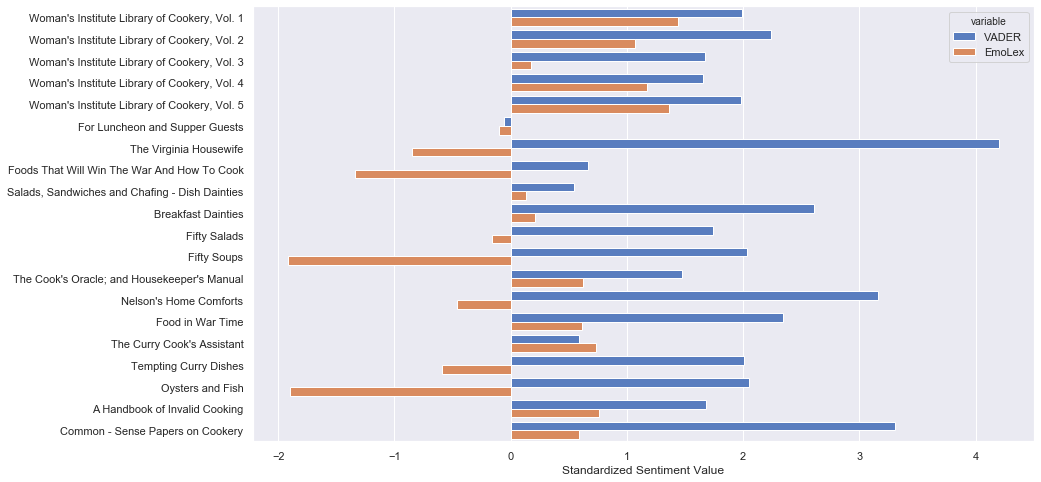

In [30]:
plt.figure(figsize=(14,8))
sns.barplot(y='book_title', x="value", hue='variable',palette="muted", data=chart_data1, orient='h')
plt.xlabel("Standardized Sentiment Value")
plt.ylabel("")
plt.show()

It's pretty clear something weird is going on, as EmoLex and VADER gives radically different assessments of each book's sentiment. 

In [31]:
sentiment_period = pd.merge(NRC_period_sentiment, VADER_sentiment_period, on=["period"])
sentiment_period


,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,book_year,nrc_anger,nrc_disgust,nrc_anticipation,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,overall_NRC_valence,VADER_pos,VADER_neg,VADER_neu,VADER_compound
period,,,,,,,,,,,,,,,,,,,,,,,
1900s,11502.489396,2.944521,106.952655,243.795167,1.814082,2.859512,14.053122,1921.324021,0.012079,0.014659,0.024473,0.013138,0.028327,0.034136,0.044949,0.019046,0.011546,0.038097,0.010813,0.055842,0.025065,0.904682,0.081663
late1800s,49093.698701,0.626005,12.167461,91.825789,8.670037,2.190098,19.023349,1887.017274,0.017409,0.017890,0.026700,0.016089,0.029762,0.041634,0.043935,0.020740,0.014472,0.037080,0.002301,0.067891,0.038268,0.887072,0.104832
mid1800s,25255.823755,2.213307,20.057594,56.253079,73.285309,0.738984,37.267902,1836.357832,0.017880,0.019037,0.027659,0.011862,0.034015,0.042578,0.046831,0.017822,0.016462,0.041845,0.004253,0.058731,0.091799,0.839658,0.091498


## Exploration of the Actual Sentiment Values to See Why the Values are so Wonky

### Vader

In [32]:
#seeing the most negative sentences from most negative book
sent_frame.query('book_id == 10582').sort_values('VADER_compound', ascending=True)[0:10]

sent_str  \
period book_id vol_num chap_num recp_num para_num sent_num                                                                                                                                                                                                                                                        
1900s  10582   0       8        110.0    1        3                                                                                                                             Fold in 3 egg whites beaten stiff 1 teaspoon vanilla 1 1/2 cups heavy cream beaten stiff and 1/2 cup nut meats broken in pieces   
                       9        120.0    1        2         Add Whites of 3 hard cooked eggs finely chopped 1 1/2 cups cooked chicken or fowl cut in cubes 1 or 2 tablespoons pimiento cut in strips 1 or 2 tablespoons green pepper cut in strips 2 tablespoons ripe olives cut in strips and Juice of 1 lemon   
                       2        27.0     1        5                                 Pour slowly onto 2 egg yolks beaten until thick and lemon colored beating constantly with egg beater until mixture will hold its shape then add Few gratings orange rind and 1/2 tablespoon orange juice and spread on cake   
                       6        80.0     1        1                                                                           Fold in 1/2 cup canned apricots cut in small pieces 1 banana cut lengthwise and crosswise in small pieces 3/4 cup pineapple cut in dice 1/2 cup maraschino cherries cut in slices   
                       4        51.0     1        4                                                                                                     Place on ice and when it begins to thicken fold in 1 1/2 cups cream beaten stiff 1/4 cup pistachio nuts shredded 1/4 cup candied cherries cut in pieces   
                       3        40.0     1        1                                                             Heat to boiling point and when sugar is dissolved add 1 tablespoon whole cloves crushed and a 2 inch piece stick cinnamon broken in pieces tied together very loosely in a piece of cheesecloth   
                       8        109.0    1        4                                                                                                                        Cool and add 1 egg yolk slightly beaten then add 1/2 cup oil gradually while beating constantly and fold in 1 egg white beaten stiff   
                       1        9.0      1        2                                                                                          Pour over 2 eggs well beaten chill and add 2 cups cream beaten stiff 1 teaspoon vanilla and 1 cup syrup drained from canned raspberries or strawberries and freeze   
                       9        125.0    1        2                                                                                                                                  Add 1 cup celery cut lengthwise and crosswise in small pieces and 1 cup shelled Brazil nuts peeled and cut in small pieces   
                       5        63.0     1        0                                          Measure 1/2 cup mayonnaise dressing add 1/4 cup chili sauce 1 tablespoon pimiento cut in small pieces 1 tablespoon green pepper cut in small pieces and 1 tablespoon celery cut in small pieces and mix thoroughly   

                                                            VADER_pos  \
period book_id vol_num chap_num recp_num para_num sent_num              
1900s  10582   0       8        110.0    1        3             0.043   
                       9        120.0    1        2             0.000   
                       2        27.0     1        5             0.000   
                       6        80.0     1        1             0.000   
                       4        51.0     1        4             0.000   
                       3        40.0     1        1             0.000   
                       8  

Based on the above, it's pretty clear it's not translating well to the domain of cookbooks

In [33]:
#placeholder for similar exploratory querries -- I'm leaving it with the most positive word from the most positive book
sent_frame.query('book_id == 12519').sort_values('VADER_compound', ascending=False)[0:10]

sent_str  \
period   book_id vol_num chap_num recp_num para_num sent_num                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
mid1800s 12519   0       10       196.0    1        0                                                                                                                                                                                                                              To have this delicate dish in perfection the lettuce pepper grass chervil cress c. should be gathered early in the morning nicely picked washed and laid in cold water which will be improved by adding ice just before dinner is ready to be served drain the water from your salad cut it into a bowl giving the proper proportions of each plant prepare the following mixture to pour over it boil two fresh eggs ten minutes put them in water to cool then take the yelks in a soup plate pour on them a table spoonful of cold water rub them with a wooden spoon until they are perfectly dissolved then add two spoonsful of oil when well mixed put in a tea spoonful of salt one of powdered sugar and one of made mustard when all these are united and quite smooth stir in two table spoonsful of common and two of tarragon vinegar put it over the salad and garnish the top with the whites of the eggs cut into rings and lay around the edge of the bowl young scallions they being the most delicate of the onion tribe   
                         12       309.0    1        0         When you find the barrel of flour a good one empty it into a chest or box made for the purpose with a lid that will shut close it keeps much better in this manner than when packed in a barrel and even improves by lying lightly sift the quantity you intend to make up put into a bowl two gills and a half of water for each quart with a tea spoon heaped up with salt and a large spoonful of yeast for each quart stir this mixture well put into another bowl one handful of flour from every quart pour a little of the mixture on to wet it then more until you get it all in taking great care that it be smooth and quite free from lumps beat it some minutes take one third of the flour out of the kettle pour on the batter and sprinkle over it the dry flour stop the kettle and set it where it can have a moderate degree of warmth when it has risen well turn it into a bowl mix in the dry flour and knead it on a board till it looks quite light return it to the kettle and place it where it can have proper heat in the morning take the dry crust carefully from the top put the dough on a board knead it well make it into rolls set them on tin sheets put a towel over and let them stand near the fire till the oven is ready   
                         6        74.0     1        0                                                                                         

### EmoLex

Looking at the words that contribute most to negative sentiment

In [34]:
NRC_emo.groupby('term_str').sum().sort_values('nrc_negative', ascending=False)[0:10]

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,book_year,nrc_anger,nrc_disgust,nrc_anticipation,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
term_str,,,,,,,,,,,,,,,,,,
fat,35228304,4290,122185,276138.0,18538,3780,29485,3171426,0.0,1666.0,0.0,0.0,0.0,1666.0,0.0,1666.0,0.0,0.0
serve,26033821,2893,94269,253875.0,13495,3592,27410,2552704,0.0,0.0,0.0,0.0,0.0,1340.0,0.0,0.0,0.0,1340.0
boil,27549810,1808,34522,123122.0,45061,1397,35867,2006973,0.0,1073.0,0.0,0.0,0.0,1073.0,0.0,0.0,0.0,0.0
lemon,26579602,2207,62210,166446.0,30976,1943,26495,1888322,0.0,1001.0,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,0.0
pound,23455112,1472,25621,114465.0,34032,946,21801,1789948,954.0,0.0,0.0,0.0,0.0,954.0,0.0,0.0,0.0,0.0
remove,14738339,1974,75856,174042.0,5265,2248,9162,1523121,797.0,0.0,0.0,797.0,0.0,797.0,0.0,797.0,0.0,0.0
case,7845540,992,37195,81648.0,2766,1277,5358,706738,0.0,0.0,0.0,370.0,0.0,370.0,0.0,370.0,0.0,0.0
grated,7731218,730,16654,54908.0,12711,489,9637,672327,357.0,0.0,0.0,0.0,0.0,357.0,0.0,0.0,0.0,0.0
bottom,7095307,753,22967,55772.0,7416,746,9417,628012,0.0,0.0,0.0,0.0,0.0,333.0,0.0,333.0,0.0,0.0


And then positive sentiment

In [36]:
NRC_emo.groupby('term_str').sum().sort_values('nrc_positive', ascending=False)[0:10]

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,book_year,nrc_anger,nrc_disgust,nrc_anticipation,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
term_str,,,,,,,,,,,,,,,,,,
cream,30817359,3213,107570,321133.0,13283,3224,24870,2822317,0.0,0.0,1480.0,0.0,1480.0,0.0,1480.0,0.0,1480.0,0.0
good,41801323,2904,70553,179292.0,48513,2798,32476,2745522,0.0,0.0,1462.0,0.0,1462.0,0.0,1462.0,0.0,1462.0,1462.0
white,23532243,2405,74948,193227.0,16292,2421,20358,1932179,0.0,0.0,1018.0,0.0,1018.0,0.0,1018.0,0.0,0.0,1018.0
top,15181510,1692,59381,141248.0,8053,2362,19580,1432867,0.0,0.0,754.0,0.0,0.0,0.0,754.0,0.0,0.0,754.0
kind,10023019,1981,81098,175504.0,2066,2099,11192,1360191,0.0,0.0,0.0,0.0,710.0,0.0,710.0,0.0,0.0,710.0
prepared,12210331,1873,62747,149158.0,8581,1633,9759,1303643,0.0,0.0,684.0,0.0,0.0,0.0,684.0,0.0,0.0,684.0
tender,12881143,1671,42306,110352.0,14732,1228,15798,1246826,0.0,0.0,0.0,0.0,659.0,0.0,659.0,0.0,0.0,659.0
clean,13407310,1311,28721,70617.0,19690,793,13950,1047400,0.0,0.0,0.0,0.0,559.0,0.0,559.0,0.0,0.0,559.0
found,13276541,1259,39772,91411.0,5516,1676,8370,1036239,0.0,0.0,0.0,0.0,544.0,0.0,544.0,0.0,0.0,544.0


Based on the contexts in which these words are likely to appear, it's clear EmoLex is also unable to effectively evaluate sentiment in cookbooks

## Pushing to .csv

In [ ]:
#sentiment_book.to_csv(data_dir + 'sentiment_book.csv')
#sentiment_period.to_csv(data_dir + 'sentiment_period.csv')